# Цели проекта: 
1. **Собрать данные о недвижимости с сайта cian.ru по району Новокосино**
2. **Преобразовать данные и сгенерировать Pandas Dataframe**
3. **Провести разведочный анализ данных**
4. **Провести работу по преобразованию признаков**
5. **Создать модель машинного обучения на основе этих данных**

In [1]:
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

## 1. Проведём веб-скрапинг данных с Cian.ru

In [2]:
prices = []
info = []
area = []
rooms = []
rem = []
floor = []
info_dict = {'prices': prices, 'area' : area, 'rooms' : rooms, 'remoteness': rem, 'floor': floor}

#### Создаём функции для сбора и преобразования данных

In [3]:
def get_price(html): 
    prices_elems = html.find_all("span", {"data-mark": "MainPrice"}) 
    for element in prices_elems:
        prices.append(element.text)
def info_func(html): 
    info = []
    info_elems = html.find_all("div", {"data-name": "GeneralInfoSectionRowComponent"}) 
    for element in info_elems:
        try:
            info.append(element.find("span", {"data-mark": "OfferSubtitle"}).text)
        except:
            info.append(element.find("span", {"data-mark": "OfferTitle"}).text)
        finally:
            continue
    info1 = list(map(lambda x: x.split(','), info)) # список, в котором хранятся элементы: количество комнат, площадь, этаж
    for i in info1:
        try:
            rooms.append(int(i[0][0]))
        except:
            rooms.append(0)
    for i in info1:
        if 'м²' in i[2]:
            ar = i[2].replace('м²', '')
            ar = ar.strip()
            area.append(f'{i[1]}.{ar}')
        else:
            area.append(i[1].replace('м²', '').strip())
    for i in info1:
        fl = i[-1].split()
        fl = fl[0].split('/')
        floor.append(round(int(fl[0]) / int(fl[1]), 2))
def get_remoteness(html):
    try:
        remoteness = html.find_all("div", {"class": "_93444fe79c--remoteness--q8IXp"})
        for i in remoteness:
            rem.append(i.text)
    except:
        rem.append('none')
    remoteness.clear()
def area_tofloat(x):
    return float(x.replace(' ', ''))
def prices_toint(x):
    return int(x[:-1].replace(' ', ''))

#### Инициализируем веб-драйвер и запустим скрипт по сбору данных с 40 страниц сайта

In [4]:
path = 'C:\Program Files (x86)\chromedriver.exe'                                        #locating chrome web-driver
driver = webdriver.Chrome(path)  

In [5]:
pages = []
status = []
dct = {'pages': pages, 'status': status}

In [6]:
driver.get('https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D=66&engine_version=2&foot_min=45&metro%5B0%5D=243&object_type%5B0%5D=1&offer_type=flat&only_foot=2')

In [7]:
cur_p = 1
while cur_p < 40:
    html = BeautifulSoup(driver.page_source, 'html.parser')
    pages = driver.find_elements(By.XPATH, "//li[@class='_93444fe79c--page--mGKWs']")
    pages_nums = html.find_all("li", {"class": "_93444fe79c--page--mGKWs"})
    for page, num in zip(pages, pages_nums):
        if num.span.text.isnumeric():  
            if int(num.span.text) <= cur_p:
                continue
            elif int(num.span.text) > cur_p:
                content = BeautifulSoup(driver.page_source, 'html.parser') 
                info_func(content)
                get_price(content)
                get_remoteness(content)
                status.append(f'{cur_p} данные собраны')
                page.click()
                cur_p += 1
                time.sleep(4)
        else:
            continue

## 2. Преобразуем данные к нужным типам и создадим Pandas DataFrame

In [8]:
prices = list(map(lambda x: int(x[:-2].replace(" ", '')), prices))
area = list(map(lambda x: float(x.strip()), area))

In [13]:
df = pd.DataFrame(info_dict)

In [14]:
df['prices'] = df['prices'].apply(prices_toint)
df['area'] = df['area'].apply(area_tofloat)

In [15]:
df.head()

,prices,area,rooms,remoteness,floor
0,7826970,35.7,1,4 минуты на транспорте,1.00
1,16200000,72.1,3,1 минута пешком,0.57
2,19500000,82.0,3,18 минут пешком,0.57
3,7900000,31.2,1,15 минут пешком,1.00
4,12450000,62.0,3,7 минут на транспорте,0.50


In [16]:
df = df.iloc[:-2]

In [17]:
df['remoteness'] = df.remoteness.str.extract('(\d+)').astype(int)

## 3. Проведем разведочный анализ данных

**Распределение цен скошено влево, а также имеет выбросы**

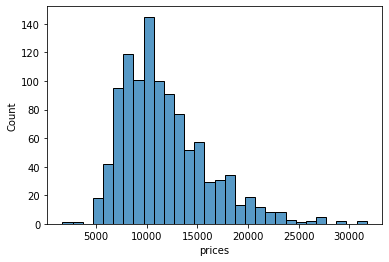

In [18]:
sns.histplot(round(df['prices'], -3)// 1000, bins=30)
plt.show()

In [19]:
df1 = df[df.prices < df.prices.quantile(.95)]

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rooms_mean = df1.groupby('rooms')['prices'].mean().reset_index()
rooms_mean

,rooms,prices
0,0,6905250.000
1,1,9117222.730
2,2,11814141.878
3,3,14052326.208
4,4,13799266.000
5,5,18000000.000


**Средняя цена по количеству комнат**

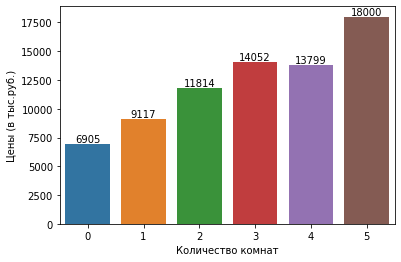

In [21]:
bar1 = sns.barplot(x=rooms_mean.rooms, y=rooms_mean.prices//1000)
for container in bar1.containers:
    bar1.bar_label(bar1.containers[0])
bar1.set(xlabel='Количество комнат', ylabel='Цены (в тыс.руб.)')
plt.show()

**Посмотрим на корреляцию данных**

<AxesSubplot:xlabel='area', ylabel='prices'>

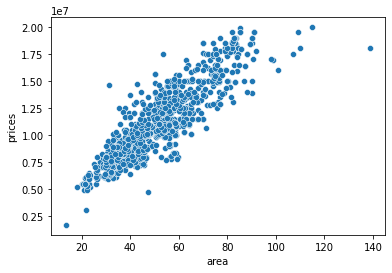

In [22]:
sns.scatterplot(x=df1.area, y=df1.prices)

<AxesSubplot:xlabel='rooms', ylabel='prices'>

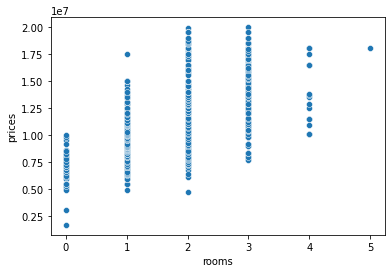

In [23]:
sns.scatterplot(x=df1.rooms, y=df1.prices)

**Можно заметить, что площадь квартиры и количество комнат коррелируют с ценой**

In [24]:
print(f' Корреляция цены с площадью квартиры: {stats.pearsonr(df1.area, df1.prices).statistic}')
print(f' Корреляция цены с площадью количеством комнат: {stats.pearsonr(df1.rooms, df1.prices).statistic}')

 Корреляция цены с площадью квартиры: 0.879151605611564
 Корреляция цены с площадью количеством комнат: 0.6378213107116987


<AxesSubplot:xlabel='floor', ylabel='prices'>

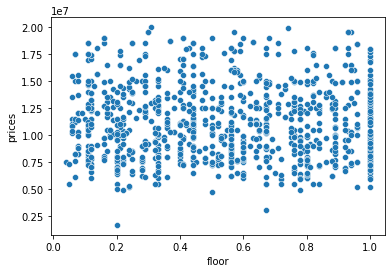

In [25]:
sns.scatterplot(x=df1.floor, y=df1.prices)

<AxesSubplot:xlabel='remoteness', ylabel='prices'>

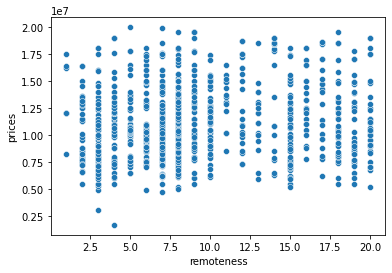

In [26]:
sns.scatterplot(x=df1.remoteness, y=df1.prices)

**Удаленность от ближайшей станции метро слабо коррелирует с ценой. Этаж не влияет на цену квартиры, так что стоит исключить данный параметр**

In [27]:
print(f' Корреляция цены с этажом: {stats.pearsonr(df1.floor, df1.prices).statistic}')
print(f' Корреляция цены с удаленностью от метро: {stats.pearsonr(df1.remoteness, df1.prices).statistic}')

 Корреляция цены с этажом: -0.023040802187407484
 Корреляция цены с удаленностью от метро: 0.10406135179621973


## 4. Преобразование признаков

**Преобразуем целевой параметр prices к натуральному логарифму. Цель: приблизить параметр к нормальному распределению.**

In [28]:
df1['prices_log'] = np.log(df1['prices'])

<AxesSubplot:xlabel='prices_log', ylabel='Count'>

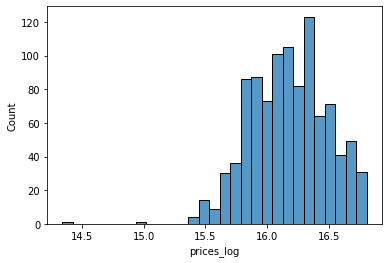

In [29]:
sns.histplot(df1.prices_log)

**Распределение логарифмов цен выглядит близко к нормальному**

In [30]:
df1.prices_log.skew()

-0.3013469755287167

<AxesSubplot:xlabel='area', ylabel='prices'>

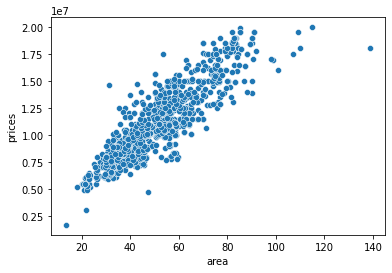

In [31]:
sns.scatterplot(x=df1.area, y=df1.prices)

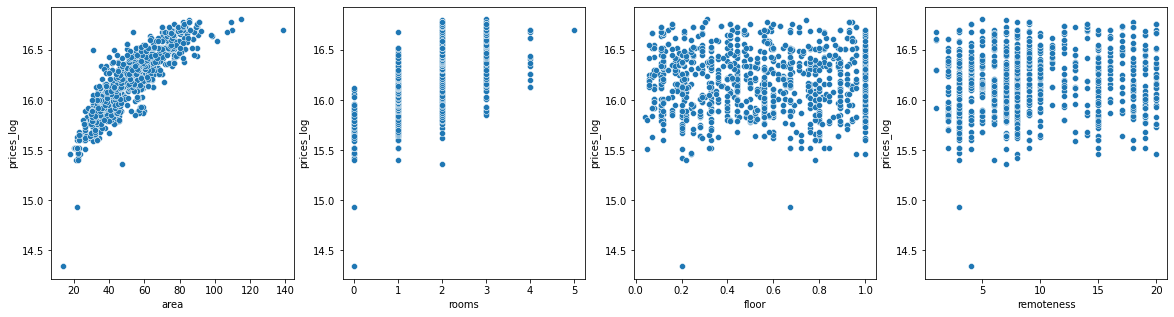

In [32]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
sns.scatterplot(x=df1.area, y=df1.prices_log, ax=axs[0])
sns.scatterplot(x=df1.rooms, y=df1.prices_log,  ax=axs[1])
sns.scatterplot(x=df1.floor, y=df1.prices_log,  ax=axs[2])
sns.scatterplot(x=df1.remoteness, y=df1.prices_log,  ax=axs[3])
plt.show()

**После логарифмирования целевого параметра (prices) корреляция практически не изменилась, поэтому стоит исключить предикторы этажа (floor) и удаленности (remoteness)**

In [33]:
print(f' Корреляция цены с площадью квартиры: {stats.pearsonr(df1.area, df1.prices_log).statistic}')
print(f' Корреляция цены с площадью количеством комнат: {stats.pearsonr(df1.rooms, df1.prices_log).statistic}')
print(f' Корреляция цены с этажом: {stats.pearsonr(df1.floor, df1.prices_log).statistic}')
print(f' Корреляция цены с удаленностью от метро: {stats.pearsonr(df1.remoteness, df1.prices_log).statistic}')

 Корреляция цены с площадью квартиры: 0.8595152335608902
 Корреляция цены с площадью количеством комнат: 0.6520526794910536
 Корреляция цены с этажом: -0.02390298119858205
 Корреляция цены с удаленностью от метро: 0.09888596488556023


## 5.Создаем модель линейной регрессии

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [35]:
df_model = df1.drop(columns=['remoteness', 'floor', 'prices'])

**Исключаем признаки удаленности и этажа**

In [36]:
df_model

,area,rooms,prices_log
0,35.700,1,15.873
1,72.100,3,16.601
2,82.000,3,16.786
3,31.200,1,15.882
4,62.000,3,16.337
...,...,...,...
1054,82.200,2,16.743
1055,82.700,2,16.760
1056,90.000,3,16.760
1057,85.100,2,16.786


**Делим данные на train и test группы**

In [37]:
modelLR = LinearRegression()

In [38]:
X = df_model.iloc[:, :-1]
y = df_model.iloc[:, -1:] 

In [39]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2)

In [40]:
modelLR.fit(Xtrain, Ytrain)

LinearRegression()

**Точность модели - 0.75. Достаточно хороший показатель**

In [41]:
train_y_pred = modelLR.predict(Xtrain)
r2_score(Ytrain, train_y_pred)

0.7485738499059391

In [42]:
y_test_pred = modelLR.predict(Xtest)
r2_score(Ytest, y_test_pred)

0.7042824737863498

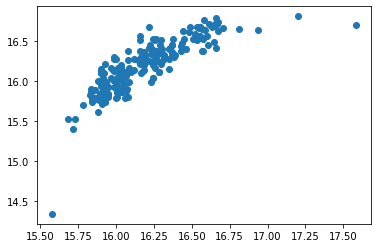

In [43]:
plt.scatter(y_test_pred, Ytest)
plt.show()

In [44]:
print(f'Mean absolute error: {mean_absolute_error(Ytest, y_test_pred)}')
print(f'Mean squared error: {mean_squared_error(Ytest, y_test_pred)}')

Mean absolute error: 0.12470308731684589
Mean squared error: 0.03208710220258862


In [45]:
prediction = np.exp(modelLR.predict([[56, 2]]))
print(round(prediction[0][0], 2))

11409338.3


**Применим другие модели, чтобы увеличить точность: RandomForestRegressor и Neural Network**

In [46]:
modelNN = MLPRegressor()
modelRF = RandomForestRegressor()

In [47]:
modelNN.fit(Xtrain, Ytrain)
modelRF.fit(Xtrain, Ytrain)

RandomForestRegressor()

In [48]:
train_y_pred_RF = modelRF.predict(Xtrain)
train_y_pred_NN = modelNN.predict(Xtrain)


**Узнаем точность моделей на тренировочных данных**

In [49]:
print(f'Точность модели Random Forest: {r2_score(Ytrain, train_y_pred_RF)}')
print(f"Точность модели Neural Network: {r2_score(Ytrain, train_y_pred_NN)}")

Точность модели Random Forest: 0.9106408215105354
Точность модели Neural Network: -29.04377250994248


**Узнаем точность моделей на тестовых данных**

In [50]:
test_y_pred_RF = modelRF.predict(Xtest)
test_y_pred_NN = modelNN.predict(Xtest)
print(f'Точность модели Random Forest: {r2_score(Ytest, test_y_pred_RF)}')
print(f"Точность модели Neural Network: {r2_score(Ytest, test_y_pred_NN)}")

Точность модели Random Forest: 0.7568505736075883
Точность модели Neural Network: -29.888617738716235


**Точность модели Random Forest на тестовых данных составила 0.76, что лучше модели линейной регрессии (0.65)**
**Точность модели Neural Network составила -30, поэтому следует отказаться от данной модели**

In [51]:
print(f'Mean absolute error: {mean_absolute_error(Ytest, test_y_pred_RF)}')
print(f'Mean squared error: {mean_squared_error(Ytest, y_test_pred)}')

Mean absolute error: 0.11240669786278404
Mean squared error: 0.03208710220258862
